In [53]:
import pandas as pd
from config import *

df = pd.read_csv(actuales)
train = pd.read_csv(train)

In [54]:
import geopandas as gpd
from shapely.geometry import Point

def filterAttributes(df: pd.DataFrame):
  data = df.copy()
  data = data.loc[data["coordX"].notna()]
  data = data.loc[data["cantBanos"].notna() & data["cantCochera"].notna() & data["cantDormitorios"].notna()]
  data = data.loc[(data["terrenoEdificado"]>data["terrenoEdificado"].quantile(0.02)) &
                  (data["terrenoEdificado"]<data["terrenoEdificado"].quantile(0.98))]
  data = data.loc[(data["precioUSD"]>data["precioUSD"].quantile(0.02)) &
                  (data["precioUSD"]<data["precioUSD"].quantile(0.98))]
  data.loc[:, "pm2"] = data["precioUSD"]/data["terrenoEdificado"]
  data = data.loc[(data["pm2"] < data["pm2"].quantile(0.99)) & (data["pm2"] > data["pm2"].quantile(0.01))]
  return data

def addNormalized(df):
  data = df.copy()
  data["terrenoEdificadoNormalized"] = (
    data["terrenoEdificado"] - data["terrenoEdificado"].mean())/data["terrenoEdificado"].std()
  data["precioUSDNormalized"] = (data["precioUSD"] - data["precioUSD"].mean())/data["precioUSD"].std()
  data.loc[:, "pm2Normalized"] = (data["pm2"] - data["pm2"].mean())/data["pm2"].std()
  
  data.loc[:, "distanciaCentroNormalized"] = (
    data["distanciaCentro"] - data["distanciaCentro"].mean())/data["distanciaCentro"].std()
  data.loc[:, "distanciaComisariaNormalized"] = (
    data["comisariaCercana"] - data["comisariaCercana"].mean())/data["comisariaCercana"].std()
  data.loc[:, "distanciaTransporteNormalized"] = (
    data["transporteCercano"] - data["transporteCercano"].mean())/data["transporteCercano"].std()
  data.loc[:, "distanciaSaludNormalized"] = (
    data["saludCercana"] - data["saludCercana"].mean())/data["saludCercana"].std()
  
  return data

def valorar_atributo(at, mean, std):
  if at<mean-2*std: return 5
  if at<mean-std: return 4
  if at<mean: return 3
  if at<mean+2*std: return 2
  if at<mean+3*std: return 1
  if at<mean+4*std: return 0
  return -1


def addValues(df):
  data = df.copy()
  data["valComisaria"] = data["comisariaCercana"].apply(lambda x: valorar_atributo(x, data["comisariaCercana"].mean(), data["comisariaCercana"].std()))
  data["valTransporte"] = data["transporteCercano"].apply(lambda x: valorar_atributo(x, data["transporteCercano"].mean(), data["transporteCercano"].std()))
  data["valSalud"] = data["saludCercana"].apply(lambda x: valorar_atributo(x, data["saludCercana"].mean(), data["saludCercana"].std()))

  data.loc[:, "valoracionServicios"] = data["valComisaria"] + data["valTransporte"] + data["valSalud"]
  data.loc[:, "valoracionServiciosNormalized"] = (data["valoracionServicios"] - data["valoracionServicios"].mean())/data["valoracionServicios"].std()

  return data

def filtMap(df):
  data = df.copy()
  barrios = gpd.read_file(map_barrios)
  geometry = [Point(xy) for xy in zip(data['coordY'], data['coordX'])]
  data_geo = gpd.GeoDataFrame(data, geometry=geometry, crs=barrios.crs)

  data = gpd.sjoin(data_geo, barrios, how="inner", op='within')
  data = data.loc[:, "tipoPropiedad":"geometry"]
  return data

def formatDF(df):
  data = filterAttributes(df)
  data = addNormalized(data)
  data = addValues(data)
  data = filtMap(data)
  return data

In [55]:
tipo_prop = "CASA"

data_test = formatDF(df.loc[df["tipoPropiedad"]==tipo_prop])
data_train = formatDF(train.loc[train["tipoPropiedad"]==tipo_prop])

C:\Users\benja\AppData\Local\Temp\ipykernel_24196\1732922273.py:3: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  data_test = formatDF(df.loc[df["tipoPropiedad"]==tipo_prop])
C:\Users\benja\AppData\Local\Temp\ipykernel_24196\1732922273.py:4: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  data_train = formatDF(train.loc[train["tipoPropiedad"]==tipo_prop])


In [70]:
data_test.loc[:, "ID"] = df["coordX"].astype(str) + "_" + df["coordY"].astype(str)
data_train.loc[:, "ID"] = train["coordX"].astype(str) + "_" + train["coordY"].astype(str)

In [62]:
merged_df = pd.merge(data_test, data_train, on='ID', how='outer', indicator=True)
df_not_in_train = merged_df[merged_df['_merge'] == 'left_only']
data_test = df_not_in_train.drop(columns=['_merge'])
data_test = data_test[data_test.columns.drop(list(df_not_in_train.filter(regex='_y')))]
data_test.columns = data_test.columns.str.replace('_x', '')

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# ...

features_knn = ['terrenoEdificado', 'distanciaCentro', 'comisariaCercana', 'transporteCercano', 'saludCercana', 'cantBanos', 'cantCochera', 'cantDormitorios', 'coordX', 'coordY']

data_for_knn_train = data_train[features_knn]
target_column = 'precioUSD'
target = data_train[target_column]

# Eliminar train_test_split y usar todo el conjunto de entrenamiento
scaler_knn = StandardScaler()
X_train_scaled = scaler_knn.fit_transform(data_for_knn_train)
y_train = target

best_rmse = float('inf')
best_r2 = -float('inf')
best_n_neighbors = 0
second_best_n_neighbors = 0
third_best_n_neighbors = 0

for n_neighbors in range(1, 11):
    knn = KNeighborsRegressor(n_neighbors=n_neighbors, algorithm='ball_tree', weights='distance')
    knn.fit(X_train_scaled, y_train)
    
    y_pred = knn.predict(X_train_scaled)  # Usar el conjunto de entrenamiento para evaluar el modelo
    r2 = r2_score(y_train, y_pred)
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    
    if (rmse < best_rmse) & (r2 > best_r2):
        best_rmse = rmse
        best_r2 = r2
        third_best_n_neighbors = second_best_n_neighbors
        second_best_n_neighbors = best_n_neighbors
        best_n_neighbors = n_neighbors

# Entrenar el modelo final con el número óptimo de vecinos
final_knn = KNeighborsRegressor(n_neighbors=best_n_neighbors, algorithm='ball_tree', weights='distance')
final_knn.fit(X_train_scaled, y_train)

# Predicciones en el conjunto de entrenamiento (puedes cambiar esto si deseas predicciones en datos de prueba)
y_pred_final = final_knn.predict(X_train_scaled)

# Evaluar el rendimiento del modelo con R^2
final_r2 = r2_score(y_train, y_pred_final)
final_rmse = np.sqrt(mean_squared_error(y_train, y_pred_final))

print(f"Mejor número de vecinos: {best_n_neighbors}")
print(f"Segundo mejor número de vecinos: {second_best_n_neighbors}")
print(f"Tercer mejor número de vecinos: {third_best_n_neighbors}\n")

# Escalar todos los datos
data_for_knn_test = data_test[features_knn]
all_data_scaled = scaler_knn.transform(data_for_knn_test)
all_data_predictions = final_knn.predict(all_data_scaled)
data_test.loc[:, 'precioUSDPredicted'] = all_data_predictions

overall_rmse = np.sqrt(mean_squared_error(data_test[target_column], all_data_predictions))
overall_r2 = r2_score(data_test[target_column], all_data_predictions)
print("Resultados en datos actuales:")
print(f"R^2 en todos los datos: {overall_r2}")
print(f"RMSE en todos los datos: {overall_rmse}")


Mejor número de vecinos: 5
Segundo mejor número de vecinos: 4
Tercer mejor número de vecinos: 3

Resultados en datos actuales:
R^2 en todos los datos: 0.7214218888186694
RMSE en todos los datos: 50750.583618287514


In [73]:
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_val_score

# Crea instancias de modelos con diferentes configuraciones
knn1 = KNeighborsRegressor(n_neighbors=best_n_neighbors, weights='distance', algorithm='brute')
knn2 = KNeighborsRegressor(n_neighbors=best_n_neighbors, weights='distance', algorithm='ball_tree')
knn3 = KNeighborsRegressor(n_neighbors=best_n_neighbors, weights='distance', algorithm='kd_tree')

# Combina los modelos mediante votación
ensemble_model = VotingRegressor(estimators=[('knn1', knn1), ('knn2', knn2), ('knn3', knn3)])

# Entrena el modelo ensamblado
ensemble_model.fit(X_train_scaled, y_train)

# Escalar todos los datos
all_data_scaled = scaler_knn.transform(data_for_knn_test)
all_data_predictions = ensemble_model.predict(all_data_scaled)
data_test.loc[:, 'precioUSDPredicted'] = all_data_predictions

# Evaluar el rendimiento del modelo con R^2
ensemble_r2 = r2_score(data_test[target_column], all_data_predictions)
print(f"R^2 en el conjunto de prueba para el modelo ensamblado: {ensemble_r2}")

R^2 en el conjunto de prueba para el modelo ensamblado: 0.7213803071794527


In [77]:
from sklearn.model_selection import GridSearchCV

# Define los modelos base
knn1 = KNeighborsRegressor()
knn2 = KNeighborsRegressor()
knn3 = KNeighborsRegressor()

# Define el modelo ensamblado
ensemble_model = VotingRegressor(estimators=[('knn1', knn1), ('knn2', knn2), ('knn3', knn3)])

# Define los parámetros a ajustar
param_grid = {
    'knn1__n_neighbors': [best_n_neighbors, second_best_n_neighbors, third_best_n_neighbors],
    'knn1__weights': ['uniform', 'distance'],  # Agrega los parámetros weights y algorithm para cada modelo
    'knn1__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    
    'knn2__n_neighbors': [best_n_neighbors, second_best_n_neighbors, third_best_n_neighbors],
    'knn2__weights': ['uniform', 'distance'],
    'knn2__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    
    'knn3__n_neighbors': [best_n_neighbors, second_best_n_neighbors, third_best_n_neighbors],
    'knn3__weights': ['uniform', 'distance'],
    'knn3__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

# Realiza la búsqueda de hiperparámetros mediante validación cruzada
grid_search = GridSearchCV(ensemble_model, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# Muestra los mejores parámetros encontrados
print("Mejores parámetros:", grid_search.best_params_)

# Predicciones en el conjunto de prueba
all_data_predictions = grid_search.predict(all_data_scaled)

# Evaluar el rendimiento del modelo con R^2
ensemble_r2 = r2_score(data_test[target_column], all_data_predictions)
print(f"R^2 en el conjunto de prueba para el modelo ensamblado: {ensemble_r2}")

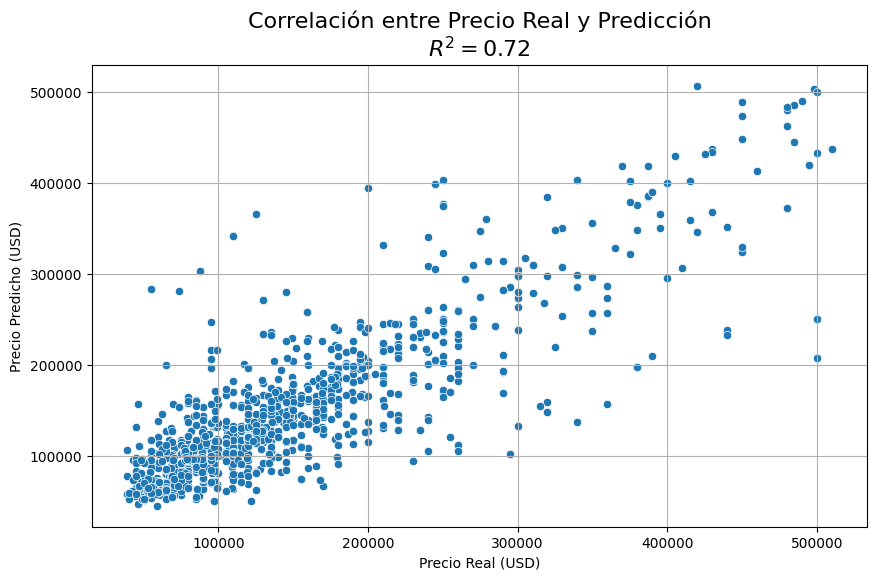

In [74]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns

# Supongamos que 'data' es tu DataFrame y 'precioUSD' es tu columna de valores reales
target = data_test['precioUSD']

# Calcula el R^2 para mostrarlo en el gráfico
ensemble_r2 = r2_score(target, all_data_predictions)

# Crea un gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(x=target, y=all_data_predictions)
plt.title(f'Correlación entre Precio Real y Predicción\n$R^2={ensemble_r2:.2f}$', fontsize=16)
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.grid(True)
plt.show()
